In [ ]:
# Helper: retry and wait helpers for Milvus operations
import time
from typing import Callable, Any

def retry_op(fn: Callable, *args, retries: int = 6, delay: float = 1.0, backoff: float = 2.0, **kwargs) -> Any:
    """Run fn(*args, **kwargs) with retries and exponential backoff. Raises last exception if all attempts fail."""
    last_exc = None
    for i in range(retries):
        try:
            return fn(*args, **kwargs)
        except Exception as e:
            last_exc = e
            wait = delay * (backoff ** i)
            print(f"Operation {getattr(fn, '__name__', str(fn))} failed (attempt {i+1}/{retries}): {e}. Retrying in {wait:.1f}s...")
            time.sleep(wait)
    raise last_exc


def wait_for_milvus_ready(client, timeout: float = 120.0, poll: float = 2.0) -> None:
    """Poll the Milvus client until it responds or timeout is reached."""
    start = time.time()
    while time.time() - start < timeout:
        try:
            # list_collections is a light-weight health call; if it works Milvus is responsive
            _ = client.list_collections()
            print("Milvus is responsive")
            return
        except Exception as e:
            print(f"Milvus not ready yet: {e}. Waiting {poll}s...")
            time.sleep(poll)
    raise RuntimeError(f"Milvus did not become ready within {timeout} seconds")


In [1]:
# Load all required Libraries
import pandas as pd
import transformers, torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset

In [2]:
from pymilvus import MilvusClient, FieldSchema, CollectionSchema, DataType

from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

# Read Passages from the Datasets and Drop rows if they are NA or empty

In [3]:
passages = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/passages.parquet/part.0.parquet")
print(passages.shape)
passages.head()

(3200, 1)


,passage
id,
0,"Uruguay (official full name in ; pron. , Eas..."
1,"It is bordered by Brazil to the north, by Arge..."
2,Montevideo was founded by the Spanish in the e...
3,The economy is largely based in agriculture (m...
4,"According to Transparency International, Urugu..."


In [4]:
# reshape the table by adding id column
passages_df = passages.reset_index()
passages_df.columns = ['id', 'passage']
passages_df.head()

,id,passage
0,0,"Uruguay (official full name in ; pron. , Eas..."
1,1,"It is bordered by Brazil to the north, by Arge..."
2,2,Montevideo was founded by the Spanish in the e...
3,3,The economy is largely based in agriculture (m...
4,4,"According to Transparency International, Urugu..."


In [5]:
# check NA or empty passages
n_na = passages_df['passage'].isna().sum()
n_empty = (passages_df['passage'].str.strip() == "").sum()

print(f"Number of NA passages: {n_na}")
print(f"Number of empty passages: {n_empty}")

Number of NA passages: 0
Number of empty passages: 0


# Do EDA on the passage dataset
- You can try to find the maximum and minimum length of the passages before indexing (just a direction)

In [6]:
# Code for EDA
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Explore the data and find some duplicated values

In [7]:
passages_df['passage'].describe()
# maybe have some duplicated values

count             3200
unique            3196
top       ; Government
freq                 3
Name: passage, dtype: object

In [8]:
counts_df = passages_df['passage'].value_counts().reset_index()
counts_df.columns = ['passage', 'cnt']
counts_df.head(5)

,passage,cnt
0,; Government,3
1,"* Pratt, H., ""Nikola Tesla 1856 1943"", Proceed...",2
2,|-,2
3,Wolves have scent glands all over their bodies...,1
4,Many of the European immigrants arrived in Uru...,1


In [9]:
passages_df[passages_df['passage'] == '; Government']

,id,passage
825,826,; Government
1367,1368,; Government
2373,2374,; Government


In [10]:
passages_df[passages_df['passage'] == counts_df.iloc[1]['passage']]

,id,passage
1511,1512,"* Pratt, H., ""Nikola Tesla 1856 1943"", Proceed..."
1517,1518,"* Pratt, H., ""Nikola Tesla 1856 1943"", Proceed..."


In [11]:
passages_df[passages_df['passage'] == counts_df.iloc[2]['passage']]

,id,passage
1910,1911,|-
1911,1912,|-


In [12]:
# remove duplicates: totally drop 4 values
passages_df = passages_df.drop_duplicates(subset=['passage']).reset_index(drop=True)
print(passages_df.shape)

(3196, 2)


In [13]:
passage_lengths = passages_df['passage'].str.len()
print(f"Max passage length: {passage_lengths.max()}")
print(f"Min passage length: {passage_lengths.min()}")
print(f"Mean passage length: {passage_lengths.mean():.2f}")

Max passage length: 2515
Min passage length: 1
Mean passage length: 390.30


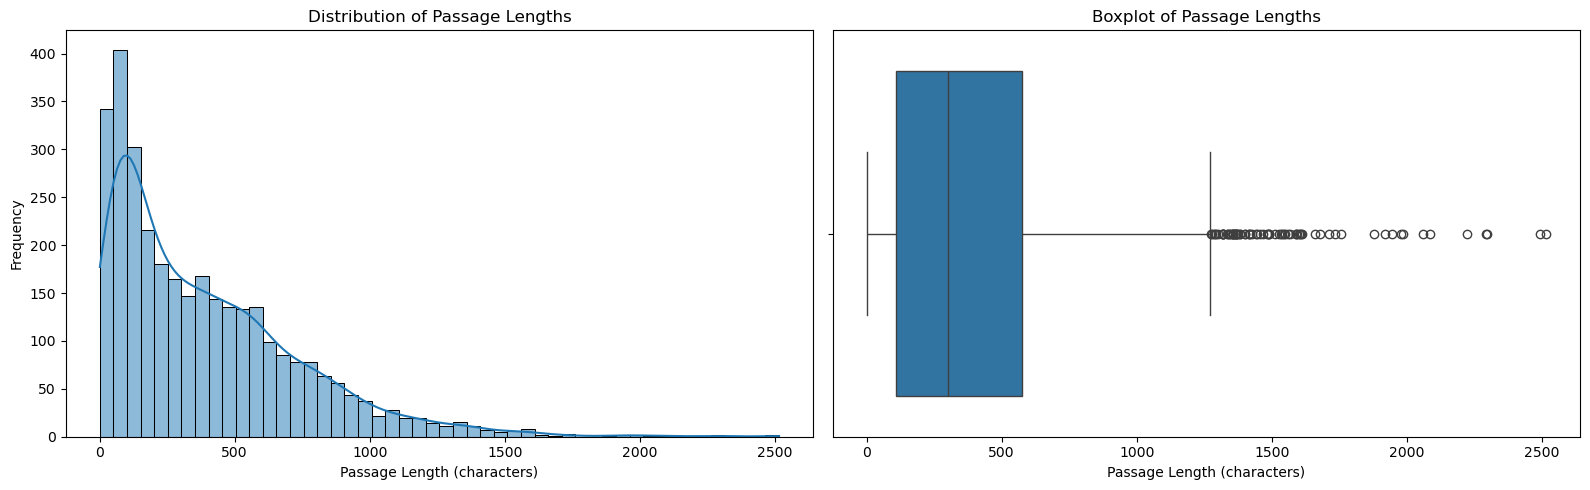

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(passage_lengths, bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Passage Lengths')
axes[0].set_xlabel('Passage Length (characters)')
axes[0].set_ylabel('Frequency')

sns.boxplot(x=passage_lengths, ax=axes[1])
axes[1].set_title('Boxplot of Passage Lengths')
axes[1].set_xlabel('Passage Length (characters)')

plt.tight_layout()

plt.show()